## Arkham Asylum Average Avocado Price Predictor

In [1]:
import pandas as pd
import numpy as np


In [2]:
avo_data = pd.read_csv("avocado.csv")

In [3]:
avo_data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,27-12-2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,20-12-2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,13-12-2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,06-12-2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,29-11-2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
avo_data.drop(["Unnamed: 0",'4046', '4225','4770' ],  axis = 1, inplace = True)

In [5]:
avo_data.columns

Index(['Date', 'AveragePrice', 'Total Volume', 'Total Bags', 'Small Bags',
       'Large Bags', 'XLarge Bags', 'type', 'year', 'region'],
      dtype='object')

### Train test split

In [6]:
# X = avo_data.copy()
# y = X.pop("AveragePrice")

In [7]:
# from sklearn.model_selection import train_test_split

# train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [8]:
avo_data.type.unique()

array(['conventional', 'organic'], dtype=object)

### Dealing with the categorical value

In [9]:
cat = avo_data.select_dtypes(include = ["object"]).columns

cat = list(cat)

cat

['Date', 'type', 'region']

In [10]:
data = avo_data.copy()

In [11]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

avo_data['type'] = label.fit_transform(avo_data['type'])

avo_data['region'] = label.fit_transform(avo_data['region'])

avo_data['Date'] = label.fit_transform(avo_data['Date'])

In [12]:
avo_data = avo_data.astype(float)

### Dealing with the null value

In [13]:
#First we will convert the date which is in the object format into the date and time format


# avo_data["Date"] = pd.to_datetime(avo_data.Date)

# avo_data.dtypes

Date            0
AveragePrice    0
Total Volume    0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64


<AxesSubplot:>

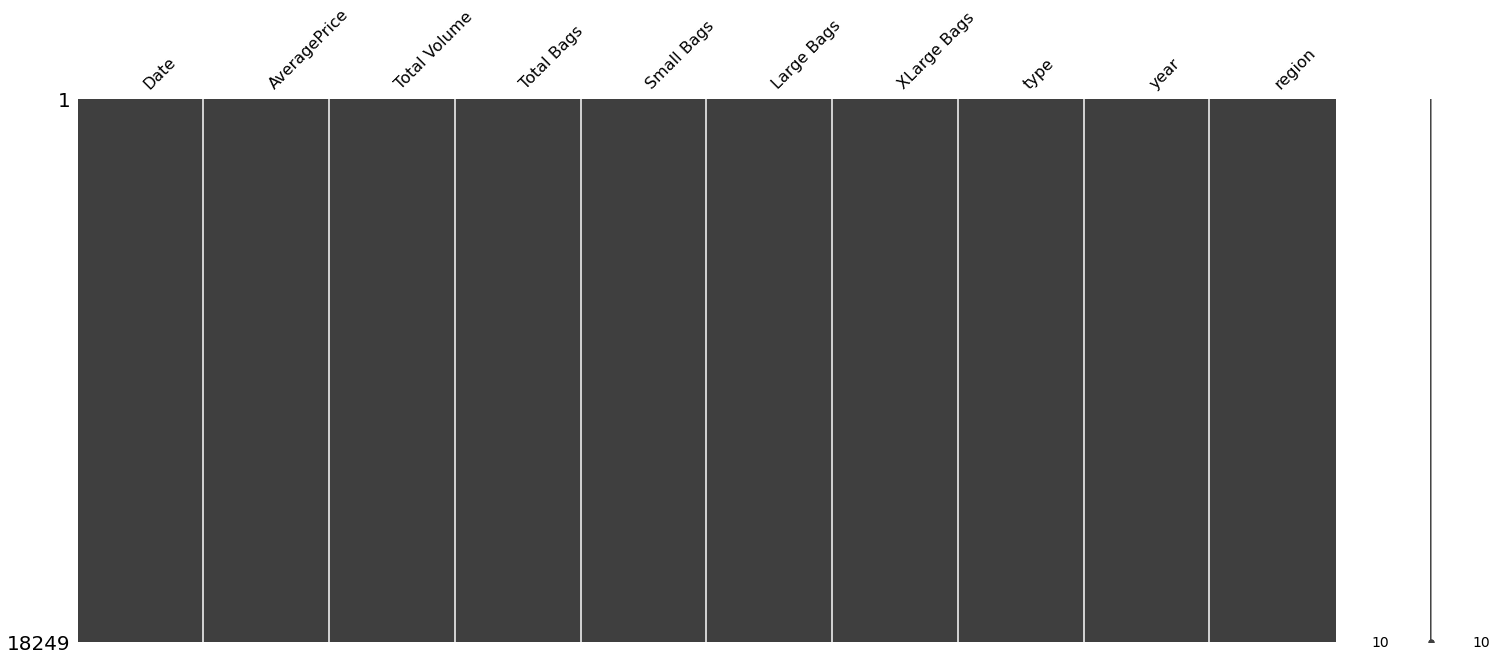

In [14]:
import missingno as msno

print(avo_data.isnull().sum())


msno.matrix(avo_data)



In [15]:
#No unncessary zero value

### Detecting Outliers With IQR

<AxesSubplot:xlabel='Total Bags', ylabel='Density'>

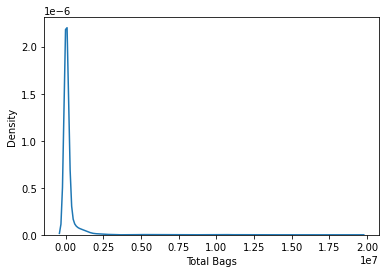

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(data = avo_data['Total Bags'])

In [17]:
avo_data.shape

(18249, 10)

In [18]:
Q1 = avo_data.quantile(0.25)

Q3 = avo_data.quantile(0.75)


IQR = Q3 - Q1

print(IQR)


Date                84.00
AveragePrice         0.56
Total Volume    422123.71
Total Bags      105694.73
Small Bags       80488.25
Large Bags       21901.78
XLarge Bags        132.50
type                 1.00
year                 2.00
region              27.00
dtype: float64


In [19]:
avo_data = avo_data[~((avo_data < (Q1 - 1.5*IQR)) | (avo_data > (Q3 + 1.5*IQR))).any(axis = 1)]

In [20]:
avo_data.shape

(12458, 10)

<AxesSubplot:xlabel='Total Bags', ylabel='Density'>

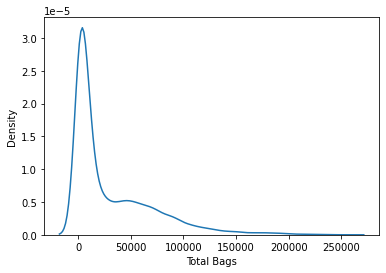

In [21]:
sns.kdeplot(data = avo_data['Total Bags'])

### Correlation Matrix

<AxesSubplot:>

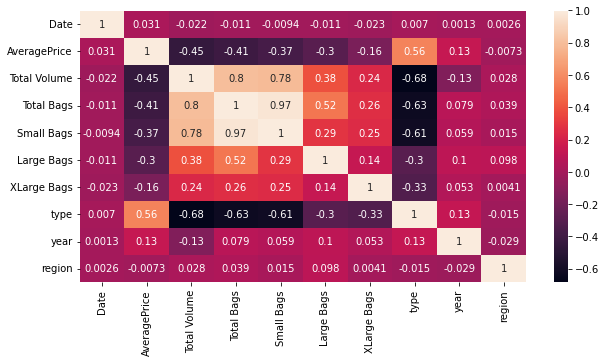

In [22]:
corr = avo_data.corr()


plt.figure(figsize = (10, 5))
sns.heatmap(corr, annot = True)

Total Volume    0.321474
Total Bags      0.288144
region          0.255643
type            0.248283
Small Bags      0.237227
Large Bags      0.190067
Date            0.127778
XLarge Bags     0.113223
year            0.040699
Name: MI_scores, dtype: float64


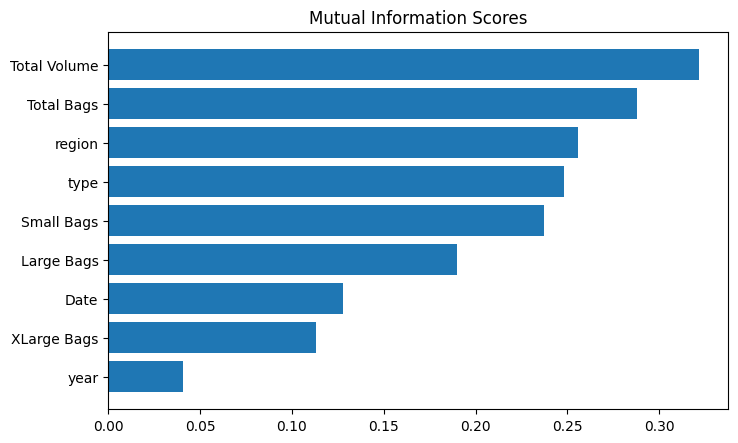

In [23]:
#To find the mutual info of the features

X_a = data.copy()
y_a = X_a.pop("AveragePrice")

discrete_features = X_a.dtypes == 'object'

for colname in X_a.select_dtypes("object"):
    X_a[colname], _ = X_a[colname].factorize()

from sklearn.feature_selection import mutual_info_regression

def make_mi_score(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores, name = "MI_scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores


mi_scores = make_mi_score(X_a, y_a, discrete_features)

print(mi_scores)


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [24]:
features = avo_data[["year", "region", "type", "Total Volume", "Total Bags"]]

In [25]:
features.dtypes

year            float64
region          float64
type            float64
Total Volume    float64
Total Bags      float64
dtype: object

<AxesSubplot:xlabel='Total Bags', ylabel='Density'>

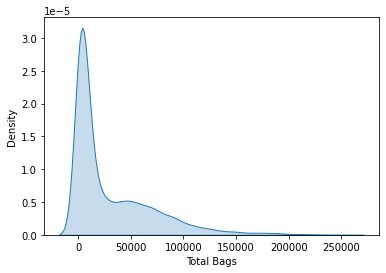

In [26]:
sns.kdeplot(data = features["Total Bags"], shade = True)

In [27]:
target = avo_data["AveragePrice"]

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 0)

In [29]:
X_test.iloc[5, :]

year              2015.00
region              26.00
type                 0.00
Total Volume    201797.82
Total Bags       44395.34
Name: 1377, dtype: float64

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

In [31]:
linear = make_pipeline(SelectKBest(k = "all"), StandardScaler(), LinearRegression())

forest = make_pipeline(SelectKBest(k = "all"), StandardScaler(), 
                       RandomForestRegressor(max_depth = 150, n_jobs = -1, random_state = 64))

In [32]:
linear.fit(X_train, y_train)
l_pred = linear.predict(X_test) 


forest.fit(X_train, y_train)
f_pred = forest.predict(X_test)

In [33]:
from sklearn.metrics import mean_absolute_error

l_mae = mean_absolute_error(y_test, l_pred)

f_mae = mean_absolute_error(y_test, f_pred)

print(f"Linear Regression:{round(l_mae, 2)}\n\nRandomForestRegressor:{round(f_mae, 2)}")

Linear Regression:0.24

RandomForestRegressor:0.12


### We are going to pick the Random forest Regressor

0.1247411717495987